In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import nltk

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
API_KEY = "QCC4AQUW1ZKX4T7P"
symbol = "ITC.BO"

In [3]:
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={API_KEY}&datatype=csv"

In [4]:
response = requests.get(url)

In [5]:
# print response
if response.status_code == 200:
    with open(f'{symbol}_stock_data.csv', 'wb') as file:
        file.write(response.content)
    print(f"Data saved to {symbol}_stock_data.csv")


Data saved to ITC.BO_stock_data.csv


In [6]:
# store the data in a pandas dataframe
df = pd.read_csv(f'{symbol}_stock_data.csv', index_col=0, parse_dates=True)

In [7]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
print(df.tail())

              open    high    low   close  volume
timestamp                                        
2025-07-01  417.90  418.85  414.7  415.20  855540
2025-07-02  416.55  416.90  411.5  412.90  627668
2025-07-03  413.60  415.70  411.3  413.55  484352
2025-07-04  415.45  415.45  411.9  412.55  617924
2025-07-07  412.55  417.10  412.1  416.15  650619


In [8]:
# Add multiple indicators
df.ta.rsi(append=True)                      # RSI
df.ta.macd(append=True)                     # MACD (MACDEXT style)
df.ta.ema(length=20, append=True)           # EMA20
df.ta.sma(length=50, append=True)           # SMA50
df.ta.obv(append=True)                      # On Balance Volume
df.ta.bbands(append=True)                   # Bollinger Bands
df.ta.cci(append=True)                      # CCI
df.ta.atr(append=True)                      # ATR

# Clean up: Drop NaN values created by indicators (lookback periods)
df.dropna(inplace=True)

In [9]:
# Calculate ADX with 14-day period (default)
adx = ta.adx(df['high'], df['low'], df['close'])

# Merge into your main DataFrame
df = pd.concat([df, adx], axis=1)

# Optional: Simplify naming
df.rename(columns={
    'ADX_14': 'ADX',
    'DMP_14': 'DI+',
    'DMN_14': 'DI-'
}, inplace=True)

In [10]:
def trend_direction(row):
    if row['ADX'] > 25:
        if row['DI+'] > row['DI-']:
            return 1   # strong uptrend
        else:
            return -1  # strong downtrend
    return 0  # no clear trend

df['trend_signal'] = df.apply(trend_direction, axis=1)

In [11]:
# Calculate MA
df['MA100'] = df['close'].rolling(100).mean()
df['MA200'] = df['close'].rolling(200).mean()
df['MA_signal'] = (df['MA100'] > df['MA200']).astype(int)

# Drop NA
df = df.dropna()

In [12]:
# 1️⃣ Select features
features = ['open', 'high', 'low', 'close', 'volume',
            'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
            'EMA_20', 'SMA_50', 'OBV', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
            'BBB_5_2.0', 'BBP_5_2.0', 'CCI_14_0.015', 'ATRr_14',
            'ADX', 'DI+', 'DI-', 'trend_signal', 'MA100', 'MA200', 'MA_signal']

# 2️⃣ Scaling features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# 3️⃣ Create sequences
X = []
y = []

sequence_length = 60  # last 60 days
target_col_index = features.index('close')  # we'll predict next 'close' price

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])
    y.append(scaled_data[i][target_col_index])  # predicting close price

X, y = np.array(X), np.array(y)
X = np.delete(X, target_col_index, axis=2)  # remove target column from X

In [13]:
model = load_model('stock_trend_model.h5')

In [14]:
# Number of test samples
num_test = len(X)

# Start from sequence_length + training size
test_dates = df.index[-num_test:]

In [15]:
# Predict
y_pred = model.predict(X)

# Inverse transform (optional)
# To get actual prices, you must inverse only the close column
# So extract only that column from original scaled data
close_scaler = MinMaxScaler()
close_scaler.fit(df[['close']])
y_pred_actual = close_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = close_scaler.inverse_transform(y.reshape(-1, 1))


149/149 [==============================] - 5s 28ms/step


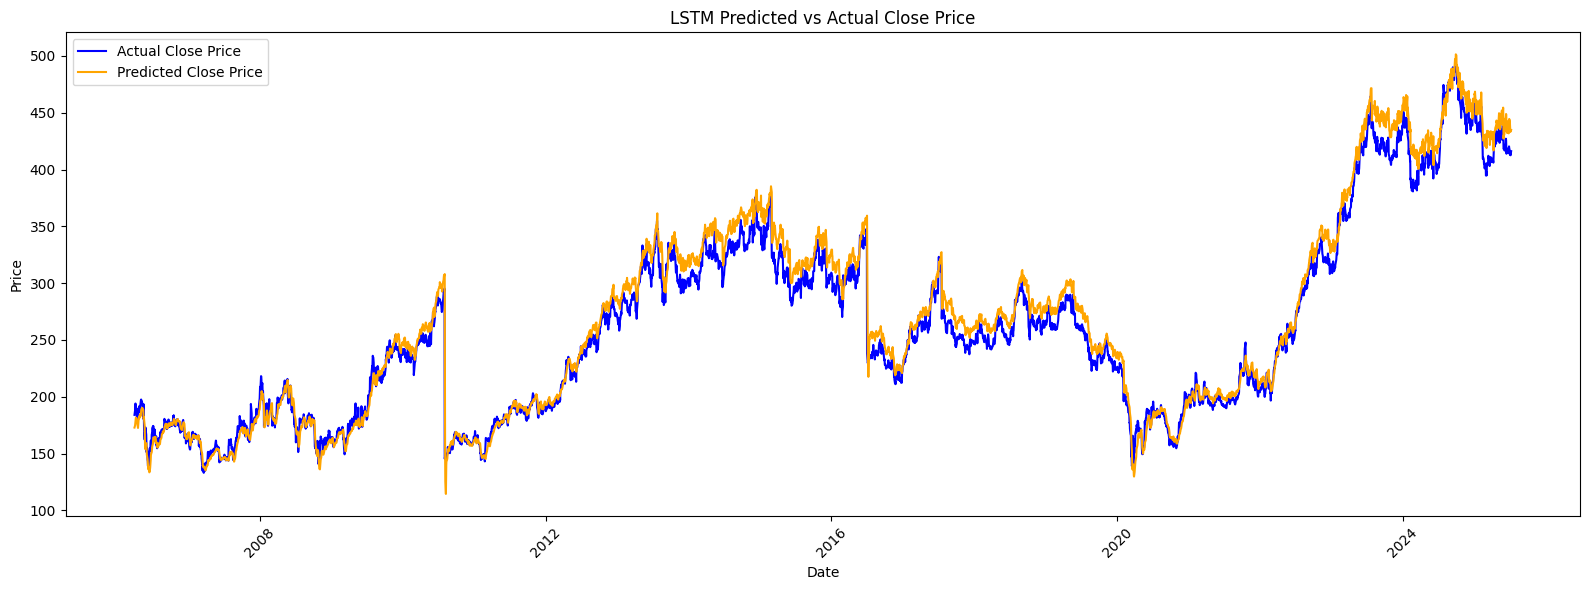

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(test_dates, y_test_actual, label='Actual Close Price', color='blue')
plt.plot(test_dates, y_pred_actual, label='Predicted Close Price', color='orange')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("LSTM Predicted vs Actual Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Inverse transform to get actual prices
y_pred_actual = close_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = close_scaler.inverse_transform(y.reshape(-1, 1))

# Flatten arrays
y_pred_actual = y_pred_actual.flatten()
y_test_actual = y_test_actual.flatten()

# 1️⃣ MAE
mae = mean_absolute_error(y_test_actual, y_pred_actual)

# 2️⃣ MSE
mse = mean_squared_error(y_test_actual, y_pred_actual)

# 3️⃣ RMSE
rmse = np.sqrt(mse)

# 4️⃣ R^2 Score
r2 = r2_score(y_test_actual, y_pred_actual)

# 5️⃣ MAPE (Optional - Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100

# 🔍 Print Results
print("📊 Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error):  {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score (R2): {r2:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


📊 Evaluation Metrics:
MAE  (Mean Absolute Error): 10.2286
MSE  (Mean Squared Error):  168.5042
RMSE (Root Mean Squared Error): 12.9809
R² Score (R2): 0.9751
MAPE (Mean Absolute Percentage Error): 3.80%


In [18]:
# Use the last 60 rows (must match scaled features)
last_60 = scaled_data[-60:]  # shape: (60, num_features)

# Remove 'close' column from each row (since you removed it during training)
last_60 = np.delete(last_60, target_col_index, axis=1)

# Reshape for LSTM input
X_input = np.reshape(last_60, (1, last_60.shape[0], last_60.shape[1]))  # (1, 60, n_features)

# Predict scaled 'close' price
predicted_scaled_close = model.predict(X_input)

# Inverse transform: put the predicted close back into a dummy row to inverse scale
# Step 1: Create a dummy row of zeros
dummy = np.zeros((1, len(features)))
# Step 2: Place predicted close value in the correct column
dummy[0][target_col_index] = predicted_scaled_close[0][0]
# Step 3: Inverse transform
predicted_close = scaler.inverse_transform(dummy)[0][target_col_index]

print(f"📈 Predicted Next 'Close' Price: {predicted_close:.2f}")

1/1 [==============================] - 0s 32ms/step
📈 Predicted Next 'Close' Price: 443.01


In [19]:
# Filter data from the last 3 years
cutoff_date = datetime.now() - timedelta(days=3*365)
df_recent = df[df.index >= cutoff_date]

In [20]:
def get_news_headlines(keyword="TCS", num_days=30):
    headlines = {}

    for i in range(num_days):
        date = datetime.now() - timedelta(days=i)
        formatted_date = date.strftime('%Y-%m-%d')
        
        # Google News RSS (can filter date later)
        url = f"https://news.google.com/rss/search?q={keyword}+when:{i}d"
        r = requests.get(url)
        soup = BeautifulSoup(r.content, features="html.parser")
        items = soup.findAll("item")

        # Limit number of headlines per day
        limited_titles = [item.title.text for item in items[:5]]  # Adjust the number as needed
        headlines[formatted_date] = limited_titles

    return headlines


In [21]:
def compute_daily_sentiment(headlines_dict):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = {}

    for date, titles in headlines_dict.items():
        scores = [analyzer.polarity_scores(title)['compound'] for title in titles]
        avg_score = sum(scores) / len(scores) if scores else 0
        sentiment_scores[date] = avg_score

    return sentiment_scores

In [22]:
headline_data = get_news_headlines(symbol, num_days=90)
sentiment_scores = compute_daily_sentiment(headline_data)

sentiment_df = pd.DataFrame(list(sentiment_scores.items()), columns=['Date', 'Sentiment'])
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df.set_index('Date', inplace=True)

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [23]:
avg_sentiment_score = sentiment_df['Sentiment'].mean()
print(f"🧠 Average Sentiment Score over 90 days: {avg_sentiment_score:.4f}")


🧠 Average Sentiment Score over 90 days: 0.0094


In [ ]:
sentiment_df.head()

In [24]:
def recompute_indicators(df):
    df['EMA_20'] = ta.ema(df['close'], length=20)
    df['SMA_50'] = ta.sma(df['close'], length=50)
    df['MA100'] = ta.sma(df['close'], length=100)
    df['MA200'] = ta.sma(df['close'], length=200)

    bbands = ta.bbands(df['close'], length=5)
    df['BBL_5_2.0'] = bbands['BBL_5_2.0']
    df['BBM_5_2.0'] = bbands['BBM_5_2.0']
    df['BBU_5_2.0'] = bbands['BBU_5_2.0']
    df['BBB_5_2.0'] = bbands['BBB_5_2.0']
    df['BBP_5_2.0'] = bbands['BBP_5_2.0']

    df['RSI_14'] = ta.rsi(df['close'], length=14)
    df['CCI_14_0.015'] = ta.cci(df['high'], df['low'], df['close'], length=14)
    df['ATRr_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)

    macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
    df['MACD_12_26_9'] = macd['MACD_12_26_9']
    df['MACDh_12_26_9'] = macd['MACDh_12_26_9']
    df['MACDs_12_26_9'] = macd['MACDs_12_26_9']

    df['OBV'] = ta.obv(df['close'], df['volume'])

    adx = ta.adx(df['high'], df['low'], df['close'], length=14)
    df['ADX'] = adx['ADX_14']
    df['DI+'] = adx['DMP_14']
    df['DI-'] = adx['DMN_14']

    # Trend signals (optional/custom)
    df['trend_signal'] = (df['MA100'] > df['MA200']).astype(int)
    df['MA_signal'] = (df['close'] > df['MA100']).astype(int)

    # Fill NA to avoid breaking scaler
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)

    return df


In [ ]:
from copy import deepcopy

df_working = deepcopy(df)  # make a copy to avoid modifying original
num_predictions = 365
k = 0.2  # sentiment scaling factor

for i in range(num_predictions):
    # 🧠 Get the last 60 rows after indicators are updated
    df_features = df_working[features].copy()
    scaled = scaler.transform(df_features)
    input_window = np.array(scaled[-60:])  # shape: (60, n_features)

    # Remove 'close' column
    input_window_no_close = np.delete(input_window, target_col_index, axis=1)

    # Reshape for LSTM input
    X_input = np.reshape(input_window_no_close, (1, 60, input_window_no_close.shape[1]))

    # 🔮 Predict scaled close
    pred_scaled_close = model.predict(X_input)[0][0]

    # 💬 Apply sentiment adjustment
    pred_scaled_adjusted = pred_scaled_close + (pred_scaled_close * k * avg_sentiment_score)

    # 🎯 Create dummy row with adjusted prediction
    dummy_scaled = np.zeros((1, len(features)))
    dummy_scaled[0][target_col_index] = pred_scaled_adjusted
    predicted_close = scaler.inverse_transform(dummy_scaled)[0][target_col_index]

    # 🔁 Approximate other values from last known real/predicted row
    last_row = df_working.iloc[-1]

    new_row = {
        'open': last_row['open'],     # or predicted_close if you want to use predicted
        'high': last_row['high'],
        'low': last_row['low'],
        'close': predicted_close,
        'volume': last_row['volume'],
    }

    df_working = pd.concat([df_working, pd.DataFrame([new_row])], ignore_index=True)

    # 🧮 Recompute indicators for the entire DataFrame
    df_working = recompute_indicators(df_working)


In [35]:
predicted_future_df = df_working[-num_predictions:][['close']].copy()
predicted_future_df.columns = ['Predicted_Close']

# Add future dates
last_date = pd.to_datetime(df.index[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_predictions, freq='B')
predicted_future_df.index = future_dates

In [33]:
predicted_future_df.tail()

,Predicted_Close
2025-09-23,429.310624
2025-09-24,433.567316
2025-09-25,433.668147
2025-09-26,428.812417
2025-09-29,422.977336


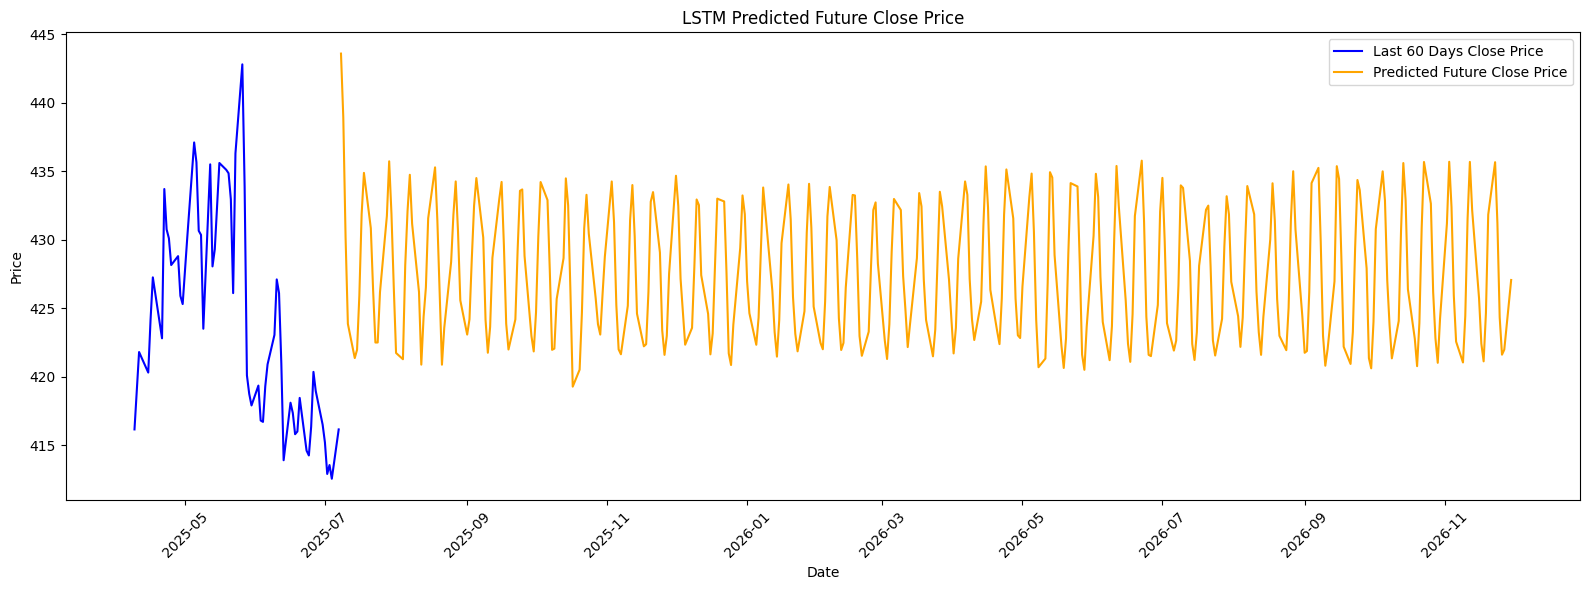

In [36]:

# Plot predicted future prices and previous 60 days
plt.figure(figsize=(16, 6))
plt.plot(df.index[-60:], df['close'][-60:], label='Last 60 Days Close Price', color='blue')
plt.plot(predicted_future_df.index, predicted_future_df['Predicted_Close'], label='Predicted Future Close Price', color='orange')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("LSTM Predicted Future Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
feature_data = scaled_data.tolist()  # for appending new predicted rows

# --- Predict next 60 days using sliding window ---
num_predictions = 365
k = 0.2  # Scaling factor — you can tune this
for _ in range(num_predictions):
    input_window = np.array(feature_data[-60:])
    
    input_window_no_close = np.delete(input_window, target_col_index, axis=1)
    X_input = np.reshape(input_window_no_close, (1, 60, input_window_no_close.shape[1]))

    # 📌 Step 1: Predict base LSTM output
    pred_scaled_close = model.predict(X_input)[0][0]

    # 📌 Step 2: Apply sentiment adjustment in scaled space
    adjusted_pred_scaled = pred_scaled_close + (pred_scaled_close * k * avg_sentiment_score)

    # 📌 Step 3: Inject adjusted close into new row
    next_row_scaled = input_window[-1].copy()
    next_row_scaled[target_col_index] = adjusted_pred_scaled

    # 📌 Step 4: Append adjusted row to sequence
    feature_data.append(next_row_scaled)

# --- Recover predicted future close prices ---
predicted_scaled_rows = np.array(feature_data[-num_predictions:])  # last 60 predicted days

# Create dummy rows to inverse transform and extract 'close'
dummy_full = np.zeros((num_predictions, len(features)))
dummy_full[:, target_col_index] = predicted_scaled_rows[:, target_col_index]

# Inverse transform only close values
recovered_close = scaler.inverse_transform(dummy_full)[:, target_col_index]



1/1 [==============================] - 0s 18ms/step


In [113]:
# Add predictions to the DataFrame
last_date = pd.to_datetime(df.index[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_predictions, freq='B')

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': recovered_close
})


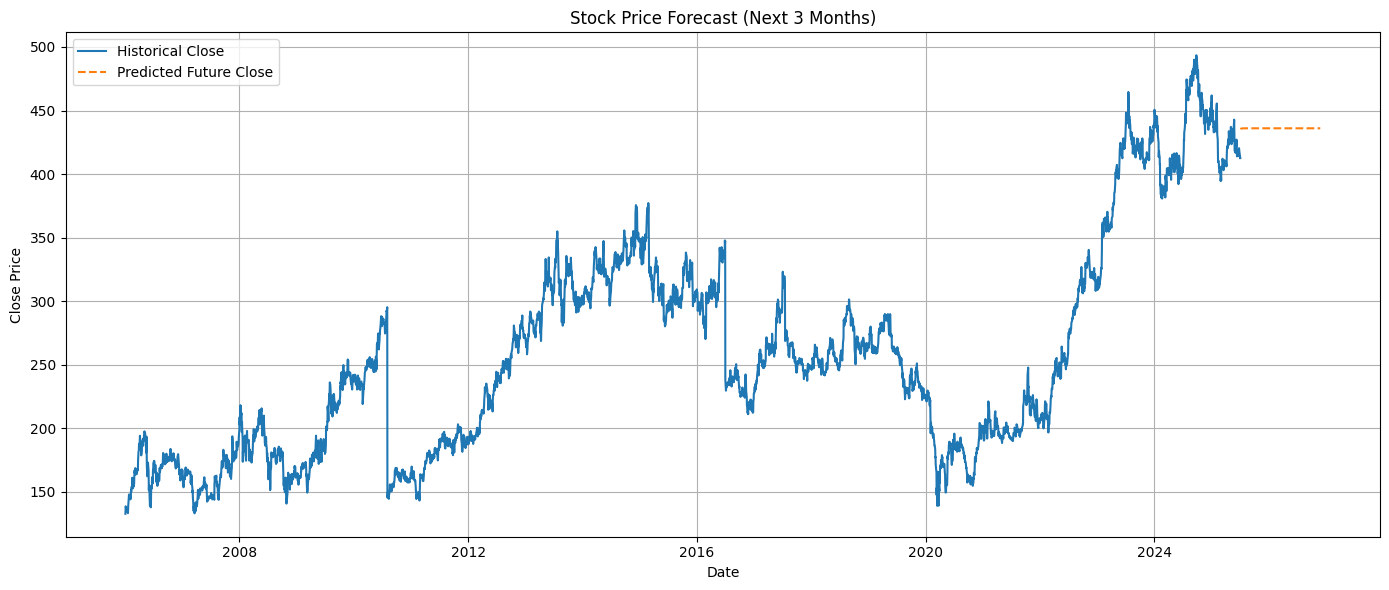

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Use the index of the original DataFrame as the x-axis
plt.plot(df.index, df['close'], label='Historical Close')

# Use future_df['Date'] for future predictions (already generated above)
plt.plot(future_df['Date'], future_df['Predicted_Close'], label='Predicted Future Close', linestyle='dashed')

plt.title('Stock Price Forecast (Next 3 Months)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [116]:
# print future_df
print(future_df)


          Date  Predicted_Close
0   2025-07-07       435.161607
1   2025-07-08       435.454402
2   2025-07-09       435.625343
3   2025-07-10       435.743968
4   2025-07-11       435.826209
..         ...              ...
360 2026-11-23       435.997882
361 2026-11-24       435.997882
362 2026-11-25       435.997882
363 2026-11-26       435.997882
364 2026-11-27       435.997882

[365 rows x 2 columns]
